#  **Setup and checks**





In [0]:
import tensorflow as tf
if tf.__version__!="2.0.0-beta1":
  !pip install --upgrade tensorflow-gpu==2.0.0b1
  print("updated Tensorflow library")
import os
%matplotlib inline
from glob import glob
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
import tensorflow_datasets as tfds

assert tf.__version__=="2.0.0-beta1", "Upgrade tf, then restart runtime"
assert tf.test.is_gpu_available(), "Connect GPU"

keras = tf.keras
from keras.layers import Activation, Conv2D, Layer
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/chest_xray_pneumonia")
!pwd &ls

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/chest_xray_pneumonia
 Attention.py
 chest_xray
'Copy of DAResNet.ipynb'
'Copy of ResNet.ipynb'
 DAResNet.ipynb
 Data_exploration.ipynb
 hello_test.txt
 inception_log.txt
 main_inception_incremental.ipynb
 main_inception.ipynb
 main.ipynb
 main_ResNet.ipynb
 Models_ensemble.ipynb
 Paper
 Prepare_Kaggle.ipynb
 __pycache__
 ResNet.ipynb
 ResNet_log.txt
 resnet_train_cache.tf-data_0.data-00000-of-00001.tempstate476731692081975760
 resnet_tr

(256, 256, 3)


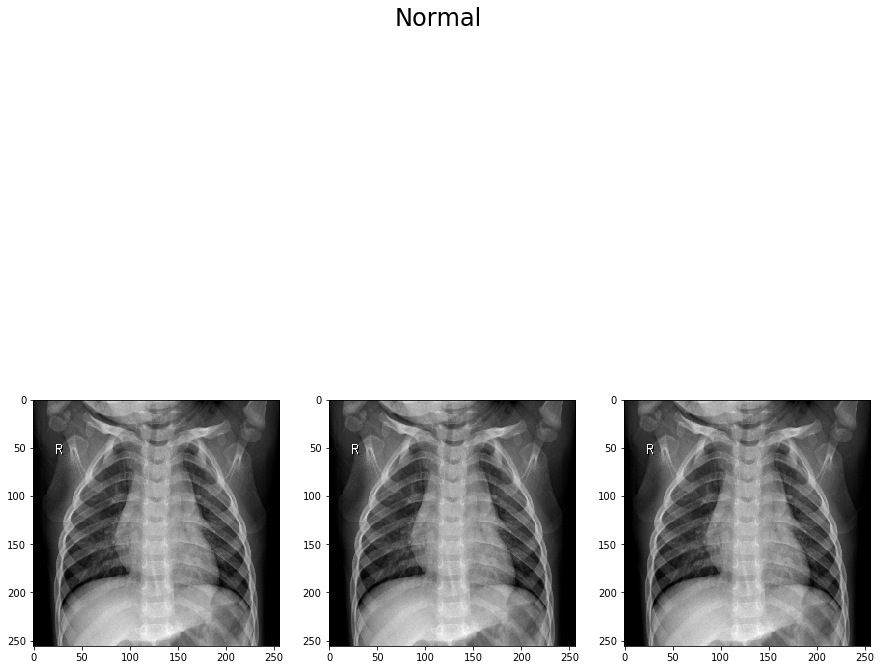

(256, 256, 3)


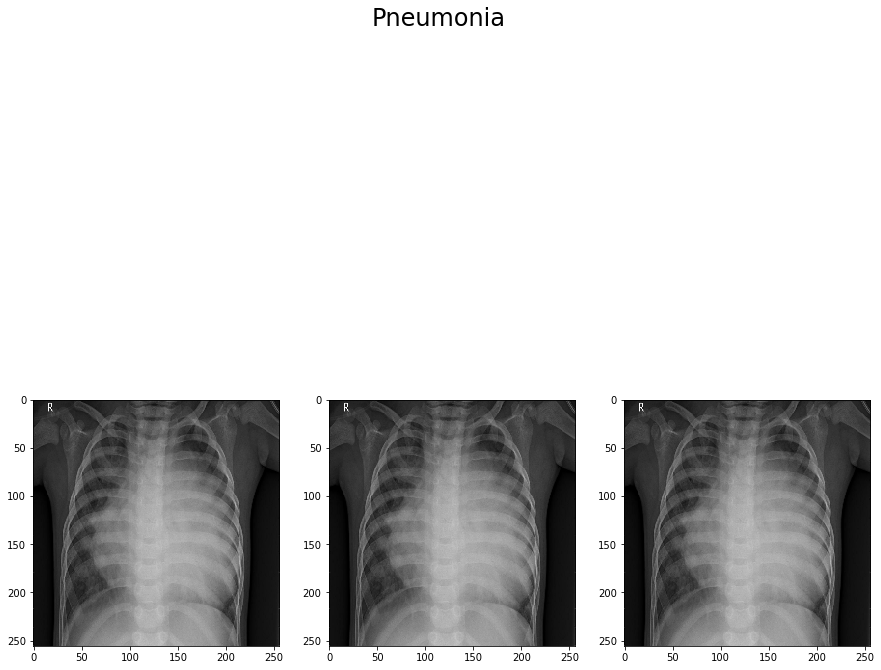

For train normal:
	No of imgs available: 0

For train pneumonia:
	No of imgs available: 0
      No of bactrial pneumonia: 0
      No of viral pneumonia: 0




For val normal:
	No of imgs available: 0

For val pneumonia:
	No of imgs available: 0
      No of bactrial pneumonia: 0
      No of viral pneumonia: 0




For test normal:
	No of imgs available: 0

For test pneumonia:
	No of imgs available: 0
      No of bactrial pneumonia: 0
      No of viral pneumonia: 0






In [0]:
IMG_SIZE = 256 # All images will be resized to this size
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
DATA_ROOT = "/content/drive/My Drive/chest_xray_pneumonia"
ALL_LOC = pathlib.Path(DATA_ROOT + '/chest_xray/train')
label_names = sorted(item.name for item in ALL_LOC.glob('*/') if item.is_dir())
classes = ["NORMAL", "PNEUMONIA"]
splits = ['train', 'val', 'test']

test1 = '/content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
label1 = 0

test2 = '/content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person5_bacteria_16.jpeg'
label2 = 1

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = image/127.5 -1 # normalize to [-1,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def show_patient(img, label):
  img = img.numpy()
  print(img.shape)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  fig.suptitle(label_names[label].title(), fontsize=24)
#   plt.subplots_adjust(hspace=0.1, top=0.1, bottom=0.05)
  for i, ax in enumerate(axs.flat):
      ax.imshow(img[...,i], "gray")
  plt.show()

def show_patient(img, label):
  img = img.numpy()
  print(img.shape)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  fig.suptitle(label_names[label].title(), fontsize=24)
#   plt.subplots_adjust(hspace=0.1, top=0.1, bottom=0.05)
  for i, ax in enumerate(axs.flat):
      ax.imshow(img[...,i], "gray")
  plt.show()

img1 = load_and_preprocess_image(test1)
show_patient(img1, label1)

img2 = load_and_preprocess_image(test2)
show_patient(img2, label2)


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

for split in splits:
    for Class in classes:
        path = DATA_ROOT+split+'/'+Class+'/*.jpeg'
        imgs = glob(path)
        imgs.sort(key=natural_keys)
        
        print("For %s %s:"%(split, Class.lower()))
        print('\tNo of imgs available: %d'%len(imgs))
        
        if Class == "PNEUMONIA":
            bacteria = sum(1 for i in imgs if  "bacteria" in i)
            virus = sum(1 for i in imgs if  "virus" in i)
            print("      No of bactrial pneumonia: %d"%bacteria)
            print("      No of viral pneumonia: %d"%virus)
        print("")
            
    print("\n\n")



# Load data:
All images will be resized to IMG_SIZE x IMG_SIZE,  and input channels rescaled to a range of [-1,1].


In [0]:
BATCH_SIZE = 32
num_train, num_val, num_test = 5216, 16, 624
count = 16
SPLIT_PRECETNTAGE = 0.8


#DATA_ROOT = pathlib.Path(DATA_ROOT)


all_imgs_paths = list(ALL_LOC.glob('*/*.jpeg'))
all_imgs_paths = [str(path) for path in all_imgs_paths]
random.shuffle(all_imgs_paths)

label_to_index = dict((name, index) for index, name in enumerate(label_names))

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_imgs_paths]
""
image_count = len(all_imgs_paths)
split_edge = round(image_count * SPLIT_PRECETNTAGE)

train_paths, train_labels = all_imgs_paths[:split_edge], all_image_labels[:split_edge]
val_paths, val_labels =all_imgs_paths[split_edge:], all_image_labels[split_edge:] 

print(len(train_paths), len(val_paths), len(all_imgs_paths))

for i in range(5):
  print(train_labels[i], train_paths[i])

####################################################################################################
TEST_LOC = pathlib.Path(str(DATA_ROOT) + '/chest_xray/test')
test_imgs_paths = list(TEST_LOC.glob('*/*.jpeg'))
test_imgs_paths = [str(path) for path in test_imgs_paths]
random.shuffle(test_imgs_paths)

test_label_names = sorted(item.name for item in TEST_LOC.glob('*/') if item.is_dir())
test_label_to_index = dict((name, index) for index, name in enumerate(test_label_names))

test_image_labels = [test_label_to_index[pathlib.Path(path).parent.name]
                    for path in test_imgs_paths]
""
test_image_count = len(test_imgs_paths)

test_paths, test_labels = test_imgs_paths, test_image_labels

print("\nTrain images are %d image, but Test images are %d." % (len(train_paths), len(test_paths)))


for i in range(5):
  print(test_labels[i], test_paths[i])


4177 1044 5221
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person549_bacteria_2307.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person581_virus_1125.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person921_virus_1578.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person109_virus_203.jpeg
0 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0395-0001-0001.jpeg

Train images are 4177 image, but Test images are 624.
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person128_bacteria_606.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person124_bacteria_591.jpeg
1 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person69_virus_129.jpeg
0 /content/drive/My Drive/chest_xray_pneumonia/chest_xray/test/NORMAL/IM-0015-0001.jpeg
0 /content/drive/My Drive/chest_xray_pn

In [0]:
""" Building a dataset """


ds_train = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = ds_train.map(load_and_preprocess_from_path_label)

train_ds = train_ds.shuffle(buffer_size=500)
train_ds = train_ds.repeat()
training_batches = train_ds.batch(BATCH_SIZE)

ds_val = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = ds_val.map(load_and_preprocess_from_path_label)

validation_batches = val_ds.cache() # filename='./resnet_val_cache.tf-data'
validation_batches = validation_batches.batch(BATCH_SIZE)#.prefetch(1)

ds_test = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = ds_test.map(load_and_preprocess_from_path_label)

test_batches = test_ds.batch(BATCH_SIZE)#.prefetch(1)

In [0]:
baseModel = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                           include_top=False,
                                           weights='imagenet')
baseModel.trainable = False
print(len(baseModel.layers))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
175


In [0]:
baseModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
DA_input_tensor = baseModel.layers[-1].output

C = DA_input_tensor.shape[-1]
H = DA_input_tensor.shape[-3]
W = DA_input_tensor.shape[-2]
H, W, C

(8, 8, 2048)

# **Defining the dual attention layer:**
  Input shape = BxHxWxC

  CAM_reshaped = BxCx(Hxw)
  
  PAM_reshaped = Bx(Hxw)xC

In [0]:
class DA_Layer(tf.keras.layers.Layer):
  def __init__(self):
    super(DA_Layer, self).__init__()
    self.permute = tf.keras.layers.Permute((3, 1, 2), input_shape=(H, W, C))
    self.repermute_CAM = tf.keras.layers.Permute((2, 1), input_shape=(C, H*W))
    self.repermute_PAM = tf.keras.layers.Permute((2, 1), input_shape=(C//8, H*W))
    self.final_repermute = tf.keras.layers.Permute((2, 3, 1), input_shape=(C, H, W))
    self.CAM_Attention = tf.keras.layers.Attention()
    self.PAM_Attention = tf.keras.layers.Attention()

  def build(self, input_shape):
     
    self.CAM_gamma = self.add_weight(shape=(1, ),
                                     dtype=tf.float32,
                                     initializer='zeros',
                                     name='CAM_gamma',
                                     trainable=True)
    
    self.PAM_gamma = self.add_weight(shape=(1, ),
                                     initializer='zeros',
                                     name='PAM_gamma',
                                     trainable=True)

    self.conv_pamQ = keras.layers.Conv2D(C//8, 1, use_bias=False, kernel_initializer='he_normal')
    self.conv_pamK = keras.layers.Conv2D(C//8, 1, use_bias=False, kernel_initializer='he_normal')
    self.conv_pamV = keras.layers.Conv2D(C, 1, use_bias=False, kernel_initializer='he_normal')


    self.built = True        


  def call(self, input):


    x = self.permute(input) # out shape -> BxCxHxW
    x = tf.reshape(x, [BATCH_SIZE, C, -1]) # out shape -> BxCx(HxW)
    x_CAM = self.repermute_CAM(x) # out shape -> Bx(Hxw)xC

    #PAM Convolutuions:
    PAM_Qry = self.conv_pamQ(input)
    PAM_Key = self.conv_pamK(input)
    PAM_Val = self.conv_pamV(input)

    PAM_Qry = self.permute(PAM_Qry) # shape -> Bx(C//8)xHxW
    PAM_Qry = tf.reshape(PAM_Qry, [BATCH_SIZE, C//8, -1]) # shape -> Bx(C//8)x(HxW)
    PAM_Qry = self.repermute_PAM(PAM_Qry)

    PAM_Key = self.permute(PAM_Key) # shape -> Bx(C//8)xHxW
    PAM_Key = tf.reshape(PAM_Key, [BATCH_SIZE, C//8, -1]) # shape -> Bx(C//8)x(HxW)
    PAM_Key = self.repermute_PAM(PAM_Key)

    PAM_Val = self.permute(PAM_Val) # shape -> BxCxHxW
    PAM_Val = tf.reshape(PAM_Val, [BATCH_SIZE, C, -1]) # shape -> BxCx(HxW)
    PAM_Val = self.repermute_PAM(PAM_Val)

    # Applying Self-Attention:
    x_CAM = self.CAM_Attention([x_CAM,x_CAM])
    x_CAM = self.CAM_gamma*x_CAM
    x_PAM = self.PAM_Attention([PAM_Qry, PAM_Val, PAM_Key])
    x_PAM = self.PAM_gamma*x_PAM

    #Reshaping again to match input shape:
    x_CAM = self.repermute_CAM(x_CAM) # x_PAM out shape -> BxCx(HxW)
    x_PAM = tf.reshape(x_PAM, [BATCH_SIZE, C, H, W]) # x_PAM shape -> BxCxHxW 
    x_CAM = tf.reshape(x_CAM, [BATCH_SIZE, C, H, W]) # x_CAM shape -> BxCxHxW
    x_PAM = self.final_repermute(x_PAM) # x_PAM shape -> BxHxWxC
    x_CAM = self.final_repermute(x_CAM) # x_CAM shape -> BxHxWxC

    DA_tensor = tf.math.add(x_CAM, x_PAM)
    out = tf.math.multiply(input, DA_tensor)
    
    return out


In [0]:
DA_layer = DA_Layer()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

dense_layer = keras.layers.Dense(2)




# > **Now building and compiling our model:**

1.   Stacking baseModel with the classifier head.
2.   Compiling the model.




In [0]:

train_new_model = True
if(train_new_model == True):
  model = tf.keras.Sequential([
                              baseModel,
                              DA_layer,
                              global_average_layer,
                              dense_layer
                              ])
else:
  model = tf.keras.models.load_model('./inception_v3_model.h5')



In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
da__layer (DA_Layer)         (32, 8, 8, 2048)          5242882   
_________________________________________________________________
global_average_pooling2d (Gl (32, 2048)                0         
_________________________________________________________________
dense (Dense)                (32, 2)                   4098      
Total params: 28,834,692
Trainable params: 5,246,980
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
DA_input_tensor = baseModel.layers[-1].output

In [0]:
baseModel.layers[-1].output

<tf.Tensor 'activation_48/Identity:0' shape=(None, 8, 8, 2048) dtype=float32>

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
da__layer (DA_Layer)         (32, 8, 8, 2048)          5242882   
_________________________________________________________________
global_average_pooling2d (Gl (32, 2048)                0         
_________________________________________________________________
dense (Dense)                (32, 2)                   4098      
Total params: 28,834,692
Trainable params: 5,246,980
Non-trainable params: 23,587,712
_________________________________________________________________




# Train the last two layers of the model:
baseModel is frozen, only the added layers are being trained.



In [0]:
print(test_batches.take(1))

In [0]:
# num_train, num_val, num_test = 5216, 16, 624

validation_steps = 5

no_epochs = 10
steps_per_epoch=tf.math.ceil(len(all_imgs_paths)/BATCH_SIZE).numpy()

loss0,accuracy0 = model.evaluate(test_batches, steps = 5) #validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


5/5 [==============================] - 43s 9s/step - loss: 9.5442 - accuracy: 0.3812
initial loss: 9.54
initial accuracy: 0.38


In [0]:
print(model.fit.__doc__)

Trains the model for a fixed number of epochs (iterations on a dataset).

    Arguments:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
            (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
            (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
            if the model has named inputs.
          - A `tf.data` dataset or a dataset iterator. Should return a tuple
            of either `(inputs, targets)` or
            `(inputs, targets, sample_weights)`.
          - A generator or `keras.utils.Sequence` returning `(inputs, targets)`
            or `(inputs, targets, sample weights)`.
        y: Target data. Like the input data `x`,
          it could be either Numpy array(s) or TensorFlow tensor(s).
          It should be consistent with `x` (you cannot have Numpy inputs and
          tensor targets, or inverse

In [0]:
history = model.fit(training_batches,
                    epochs=30, #no_epochs,
                    validation_data=validation_batches,
                    validation_steps= 5, #validation_steps,
                    steps_per_epoch=5)

Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 224s 45s/step - loss: 10.9903 - accuracy: 0.2875 - val_loss: 11.9543 - val_accuracy: 0.2250
Epoch 2/30
5/5 [==============================] - 44s 9s/step - loss: 10.7975 - accuracy: 0.3000 - val_loss: 11.9543 - val_accuracy: 0.2250
Epoch 3/30
5/5 [==============================] - 52s 10s/step - loss: 11.3759 - accuracy: 0.2625 - val_loss: 11.9543 - val_accuracy: 0.2250
Epoch 4/30
5/5 [==============================] - 47s 9s/step - loss: 12.1471 - accuracy: 0.2125 - val_loss: 11.9543 - val_accuracy: 0.2250
Epoch 5/30
5/5 [==============================] - 58s 12s/step - loss: 10.6047 - accuracy: 0.3125 - val_loss: 11.9543 - val_accuracy: 0.2250
Epoch 6/30
5/5 [==============================] - 46s 9s/step - loss: 12.2436 - accuracy: 0.2062 - val_loss: 11.9543 - val_accuracy: 0.2250
Epoch 7/30
5/5 [==============================] - 47s 9s/step 

In [0]:
model.evaluate(test_batches, steps = validation_steps)

5/5 [==============================] - 2s 301ms/step - loss: 9.5442 - accuracy: 0.3812


[9.544186973571778, 0.38125]



# Fine tune the model:



In [0]:
baseModel.trainable = True

fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
da__layer (DA_Layer)         (32, 8, 8, 2048)          5242882   
_________________________________________________________________
global_average_pooling2d (Gl (32, 2048)                0         
_________________________________________________________________
dense (Dense)                (32, 2)                   4098      
Total params: 28,834,692
Trainable params: 28,767,684
Non-trainable params: 67,008
_________________________________________________________________


In [0]:
no_epochs = 30
fine_tune_epochs = 100
total_epochs =  no_epochs + fine_tune_epochs

history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
                         steps_per_epoch = 5,
                         validation_data = validation_batches)


Epoch 31/130
4/5 [=======================>......] - ETA: 1s - loss: 10.6047 - accuracy: 0.3125

InvalidArgumentError: ignored

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [0]:
model.evaluate(test_batches, steps = validation_steps)

In [0]:
!pwd

In [0]:
model.save('./DAResNet_model.h5')

In [0]:
model.summary()

In [0]:
f = open("DAResNet_log.txt", "a")

acc_fine = []
val_acc_fine = []
loss_fine = []
val_loss_fine = []

for i in range(5):
  fine_tune_epochs = 50 #* (i+1)
  no_epochs = 200 + 50 * (i)
  total_epochs =  no_epochs + fine_tune_epochs
  history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
                         steps_per_epoch = 5,
                         validation_data = validation_batches,
                         verbose=2)
  model.save('./DAResNet_model.h5')
  
  print("\n\nFinished loop nmber %d\nwith Total epochs of %d\n\n"% (i, total_epochs))
  f.write("%d: Finished a loop\n" % (i))
  f.write("Finished loop nmber %d\nwith Total epochs of %d\n"% (i, total_epochs))

  acc_fine.extend(history_fine.history['accuracy'])
  val_acc_fine.extend(history_fine.history['val_accuracy'])

  loss_fine.extend(history_fine.history['loss'])
  val_loss_fine.extend(history_fine.history['val_loss'])
  

f.close()


In [0]:
model.evaluate(test_batches, steps = 5)

In [0]:
flatten = lambda l: [item for sublist in l for item in sublist]
# x = flatten(list(acc_fine))
# xx = flatten(val_acc_fine)
# y = flatten(loss_fine)
# yy = flatten(val_loss_fine)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc_fine, label='Training Accuracy')
plt.plot(val_acc_fine, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_fine, label='Training Loss')
plt.plot(val_loss_fine, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')